In [1]:
import numpy as np
from datasets import load_dataset, load_from_disk
from pixel_datasets.dataset_transformations import SyntheticDatasetTransform, SimpleTorchTransform  
from pixel_datasets.pixel_dataset_generator import PretrainingDataset
from pixel_datasets.glue_dataset_generator import GlueDatasetForPixel
import wandb
from PIL import Image
from pixel_datasets.utils.squad_utils import (
    generate_pixel_mask_from_recangles,
    merge_rectangle_lines,
    convert_pixel_mask_to_patch_mask,
)
from pixel_datasets.utils.dataset_utils import (
    generate_patch_mask,
)
from pixel_datasets.utils.utils import plot_arrays

from pixel import (
    AutoConfig,
    AutoModelForSequenceClassification,
    PIXELForSequenceClassification,
    PIXELForPreTraining,
    PIXELTrainer,
    PIXELTrainingArguments,
    PoolingMode,
    PIXELConfig
)
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from scipy.ndimage import binary_erosion
from pixel.utils.inference import predict, parse_outputs


In [2]:
rng = np.random.RandomState(2)
wandb.init(config="/home/knf792/PycharmProjects/pixel-2/configs/pretraining_config.yaml", mode="disabled")
args = wandb.config

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
def load_model(args, model_name):
    config_kwargs = {
        "cache_dir": args.model_cache_dir,
        "revision": args.model_revision,
        "use_auth_token": args.use_auth_token,
    }
    config = PIXELConfig.from_pretrained(
            model_name,
            attention_probs_dropout_prob=args.dropout_prob,
            hidden_dropout_prob=args.dropout_prob,
            **config_kwargs,
        )
    
    # Adapt config
    config.update(
        {
            "mask_ratio": args.mask_ratio,
            "norm_pix_loss": args.norm_pix_loss,
            "architectures": [PIXELForPreTraining.__name__],
        }
    )
    model = PIXELForPreTraining.from_pretrained(
            args.model_name_or_path,
            from_tf=bool(".ckpt" in args.model_name_or_path),
            config=config,
            **config_kwargs,
        )
    return model

def load_real_dataset(rng):
    dataset = load_dataset("Nadav/CaribbeanScans", split="test", cache_dir="/projects/copenlu/data/nadav/cache").select(range(1000))
    return dataset

In [6]:
def get_mask_edges(mask, times = 1):
  # mask is a 2D numpy array of 0s and 1s
  # return an array of the same size where only the edges of each connected component are 1
  # use binary erosion to shrink each component by one pixel
  eroded_mask = binary_erosion(mask)
  for _ in range(times - 1):
    eroded_mask = binary_erosion(eroded_mask)
  # subtract the eroded mask from the original mask to get the edges
  edges = mask - eroded_mask
  # return the edges as an array of 0s and 1s
  return edges


def generate_mask_from_coordinates(x, y, h, w):
    mask = np.zeros((23, 23))
    mask[x:x+w, y:y+h] = 1
    return mask
    

def random_pixel_masking(config, image_size):
    """
    Generate a random mask for the image.
    """
    mask_shape = image_size / np.array(config.patch_base_size)
    assert mask_shape[0] == int(mask_shape[0]), "Mask shape is not an integer"
    assert mask_shape[1] == int(mask_shape[1]), "Mask shape is not an integer"

    mask_shape = mask_shape.astype(int)
    mask = np.zeros(mask_shape)
    patches_masked = 0
    while (
        patches_masked / (mask_shape[0] * mask_shape[1])
    ) < config.mask_block_probability:
        patch_height = 1
        patch_width = rng.randint(1, 6 + 1)

        for _ in range(10):
            random_mask_location_x = 0
            random_mask_location_y = rng.randint(mask_shape[1] - patch_width + 1)

            slice = mask[
                random_mask_location_x : random_mask_location_x + patch_height,
                random_mask_location_y : random_mask_location_y + patch_width,
            ]
            if np.sum(slice) > 0:
                continue
            else:
                mask[
                    random_mask_location_x : random_mask_location_x + patch_height,
                    random_mask_location_y : random_mask_location_y + patch_width,
                ] = 1

                patches_masked += patch_height * patch_width
                break

    pixel_mask = np.kron(mask, np.ones(config.patch_base_size))
    return pixel_mask, mask
    
    
def generate_random_mask(config, rng):
    image_size = np.array([368, 368])
    pixel_mask, patch_mask = generate_patch_mask(config, rng, image_size)
    return pixel_mask, patch_mask

    
def convert_patch_mask_to_pixel_mask(mask):
    return np.kron(mask, np.ones((16, 16)))


def merge_mask_with_image(mask, image, alpha=0.5):
    mask = np.stack([mask, mask, mask], axis=-1)
    image[mask == 1] = image[mask == 1] * alpha
    
    return image



def render_text(image_size, font_size, text, font_name):
    # create a white image of the specified size
    image = Image.new("RGB", image_size, (255, 255, 255))
    # create a draw object to draw on the image
    draw = ImageDraw.Draw(image)
    # create a font object with the specified font size
    font = ImageFont.truetype(font_name, font_size)
    # get the width and height of the text
    text_width, text_height = draw.textsize(text, font)
    # calculate the position to center the text on the image
    x = (image_size[0] - text_width) // 2
    y = (image_size[1] - text_height) // 2
    # draw the text on the image with black color
    draw.text((0, 0), text, (0, 0, 0), font)
    # convert the image to a numpy array and return it
    output = np.array(image)
    return output


def draw_grid(image):
  # get the height and width of the image
  height, width = image.shape[:2]
  # create a copy of the image to draw on
  output = image.copy()
  # set the color of the grid lines (white)
  color = (190, 190, 190)
  # loop through every 16 pixels in the height and width
  for y in range(0, height, 16):
    for x in range(0, width, 16):
      # draw a horizontal line from (x, y) to (x + 16, y)
      output[y, x:x+16] = color
      # draw a vertical line from (x, y) to (x, y + 16)
      output[y:y+16, x] = color
  # return the output image
  return output


def get_attention_mask(num_text_patches: int):
    """
    Creates an attention mask of size [1, seq_length]
    The mask is 1 where there is text or a [SEP] black patch and 0 everywhere else
    """
    n = min(
        num_text_patches + 1, 529
    )  # Add 1 for [SEP] token (black patch)
    zeros = torch.zeros(529)
    ones = torch.ones(n)
    zeros[:n] = ones
    return zeros


In [5]:
model_name = "Nadav/Pixel-real-scans-v3"
model = load_model(args, model_name)
# dataset = load_real_dataset(args)

Downloading:   0%|          | 0.00/429M [00:00<?, ?B/s]

In [34]:
original = Image.open("/home/knf792/PycharmProjects/pixel-2/evaluations/sample_scans/real_scans_7_original.png")
predictions = Image.open("/home/knf792/PycharmProjects/pixel-2/evaluations/sample_scans/real_scans_7_predicted.png")
mask = Image.open("/home/knf792/PycharmProjects/pixel-2/evaluations/sample_scans/real_scans_7_pixel_mask.png")


original_with_grid = draw_grid(np.asarray(original))
original_with_grid = Image.fromarray(original_with_grid)
original_with_grid.save("/home/knf792/PycharmProjects/pixel-2/evaluations/cannon_example/original_with_grid.png")

mask = np.array(mask.copy().convert("RGB")) / 255 
original = np.asarray(original.copy().convert("RGB"))
masked = (1 - mask) *  original
masked = draw_grid(masked)
masked = Image.fromarray(masked.astype(np.uint8))
masked.save("/home/knf792/PycharmProjects/pixel-2/evaluations/cannon_example/masked_with_grid.png")

merged = draw_grid(original) * (1 - mask) + predictions * mask
only_edges = get_mask_edges(mask[:, :, 0], 3)
merged = merge_mask_with_image(only_edges, merged.copy(), alpha=0.1)
merged = Image.fromarray(merged.astype(np.uint8))
merged.save("/home/knf792/PycharmProjects/pixel-2/evaluations/cannon_example/merged_with_grid.png")

# im = np.asarray(im)
# pixel_mask, mask = generate_random_mask(args, rng)
# only_edges = get_mask_edges(pixel_mask, 3)

# merged = merge_mask_with_image(only_edges, im.copy())
# # im = draw_grid(merged)
# vis = Image.fromarray(merged)
# vis

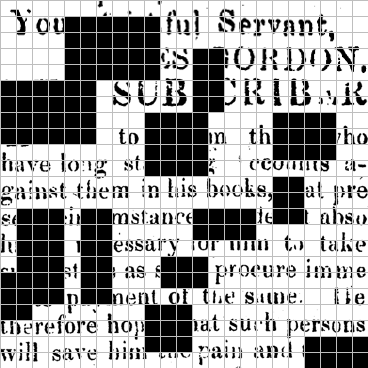

In [99]:
random_mask, _ = generate_random_mask(args, rng)
merged = merge_mask_with_image(random_mask, im)
merged = draw_grid(merged)
vis = Image.fromarray(merged)
vis.save("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/random_mask.png")
vis

/tmp/ipykernel_2018284/3542323559.py:31: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font)


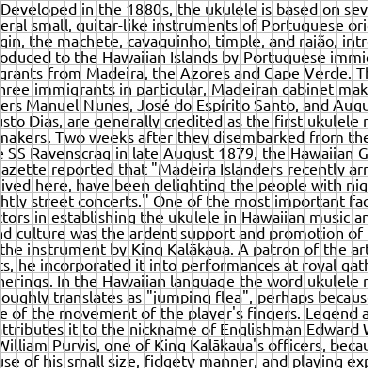

In [86]:
sentence = """Developed in the 1880s, the ukulele is based on several small, guitar-like instruments of Portuguese origin, the machete, cavaquinho, timple, and rajão, introduced to the Hawaiian Islands by Portuguese immigrants from Madeira, the Azores and Cape Verde. Three immigrants in particular, Madeiran cabinet makers Manuel Nunes, José do Espírito Santo, and Augusto Dias, are generally credited as the first ukulele makers. Two weeks after they disembarked from the SS Ravenscrag in late August 1879, the Hawaiian Gazette reported that "Madeira Islanders recently arrived here, have been delighting the people with nightly street concerts." One of the most important factors in establishing the ukulele in Hawaiian music and culture was the ardent support and promotion of the instrument by King Kalākaua. A patron of the arts, he incorporated it into performances at royal gatherings. In the Hawaiian language the word ukulele roughly translates as "jumping flea", perhaps because of the movement of the player's fingers. Legend attributes it to the nickname of Englishman Edward William Purvis, one of King Kalākaua's officers, because of his small size, fidgety manner, and playing expertise. One of the earliest appearances of the word ukulele in print (in the sense of a stringed instrument) is in the Metropolitan Museum of Art's Catalogue of the Crosby Brown Collection of Musical Instruments of All Nations published in 1907. The catalog describes two ukuleles from Hawaii—one that is similar in size to a modern soprano ukulele, and one that is similar to a tenor .
"""


image_with_text = render_text((8464, 16), 16, sentence, '/home/knf792/PycharmProjects/pixel-2/pixel_datasets/fonts/fonts/Ubuntu-R.ttf')
rolled_image = np.vstack(np.split(image_with_text, 23, axis=1))
rolled_image = draw_grid(rolled_image)
vis = Image.fromarray(rolled_image)
vis.save("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/PIXEL_sentence_with_grid.png")
vis

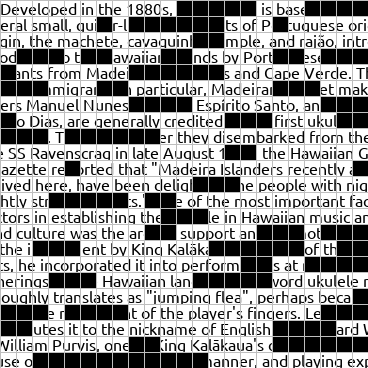

In [97]:
mask, _ = random_pixel_masking(args, (16, 8464))
merged = merge_mask_with_image(mask, image_with_text)
rolled_image = np.vstack(np.split(merged, 23, axis=1))
rolled_image = draw_grid(rolled_image)
vis = Image.fromarray(rolled_image)
vis.save("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/PIXEL_sentence_with_mask_and_grid.png")
vis

/tmp/ipykernel_90387/1777724809.py:168: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/utils/tensor_numpy.cpp:172.)
  original_img = torch.from_numpy(original_img.transpose(2, 0, 1))


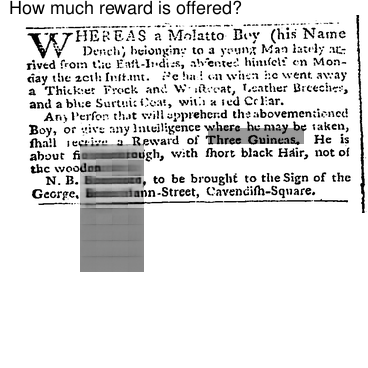

In [7]:
im = Image.open("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/pixel_runaways_overlay.png")
im = np.asarray(im)

outputs = predict(model, np.array(im), mask)
outputs.keys()

predictions = parse_outputs(outputs, model, im)
predictions = Image.fromarray(predictions.astype(np.uint8))
predictions

In [8]:
model_name = "/projects/copenlu/data/nadav/pixel/PretarinedPHD_v2/checkpoint-200000"
model = load_model(args, model_name)


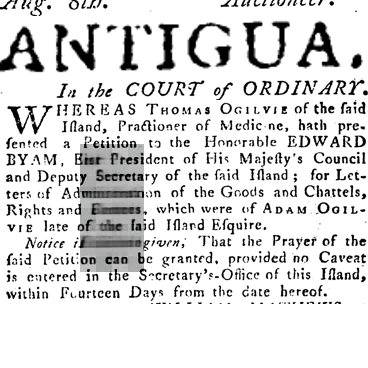

In [9]:
outputs = predict(model, im, mask)
outputs.keys()

predictions = parse_outputs(outputs, model, im)
predictions = Image.fromarray(predictions.astype(np.uint8))
predictions

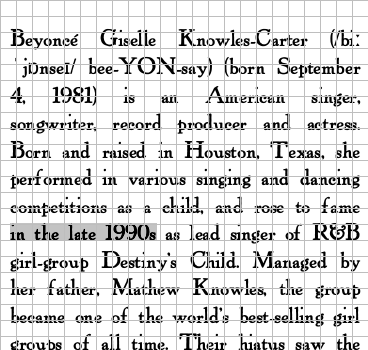

In [12]:
im = Image.open("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/visual_historical_squad_context_mask_overlay.png")
im = im.convert("RGB")
im = np.asarray(im)
im = draw_grid(im)
vis = Image.fromarray(im)
vis.save("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/visual_historical_squad_context_mask_overlay_grid.png")
vis

In [3]:
good_indixes = []
for i in range(len(dataset["train"])):
    if np.max(dataset["train"][i]["label"]) == 1:
        good_indixes.append(i)



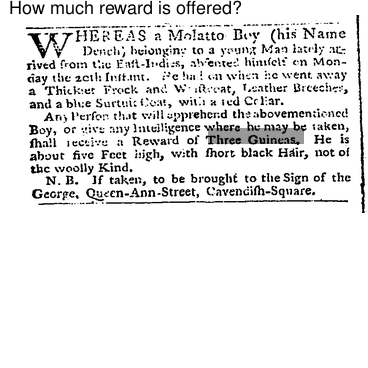

In [7]:
k = 3
# 2, 3 is good

dataset = load_from_disk("/projects/copenlu/data/nadav/Datasets/runaways_visual/dataset")
mask = np.array(dataset["train"][good_indixes[k]]['label']).astype(np.float32)
image = np.array(dataset["train"][good_indixes[k]]['image']).astype(np.float32)

pixel_mask = convert_patch_mask_to_pixel_mask(mask)
merged = merge_mask_with_image(pixel_mask, image, alpha=0.6)

vis = Image.fromarray(merged.astype(np.uint8))
vis.save("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/pixel_runaways_overlay.png")
vis

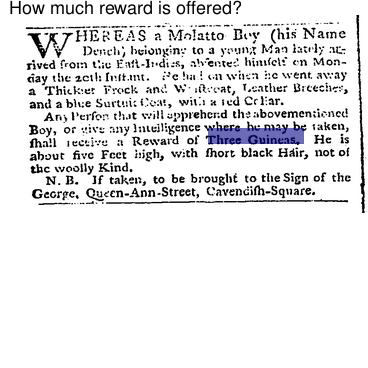

In [31]:
from skimage.color import label2rgb
res = label2rgb(pixel_mask, image.astype("uint8"), bg_label=0, bg_color=None, colors=[(0, 0, 1)])
res = Image.fromarray((res * 255).astype(np.uint8))
res

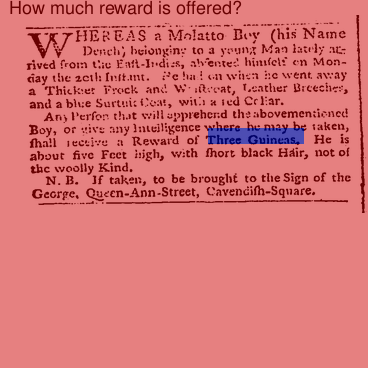

In [43]:
import cv2
heatmap = cv2.applyColorMap((pixel_mask * 255).astype("uint8"), cv2.COLORMAP_JET)
weight = cv2.addWeighted(image.astype("uint8") ,0.5, heatmap.astype("uint8") ,0.8 ,0.3)
weight = Image.fromarray(weight.astype(np.uint8))


In [39]:
help(cv2.addWeighted)

Help on built-in function addWeighted:

addWeighted(...)
    addWeighted(src1, alpha, src2, beta, gamma[, dst[, dtype]]) -> dst
    .   @brief Calculates the weighted sum of two arrays.
    .   
    .   The function addWeighted calculates the weighted sum of two arrays as follows:
    .   \f[\texttt{dst} (I)= \texttt{saturate} ( \texttt{src1} (I)* \texttt{alpha} +  \texttt{src2} (I)* \texttt{beta} +  \texttt{gamma} )\f]
    .   where I is a multi-dimensional index of array elements. In case of multi-channel arrays, each
    .   channel is processed independently.
    .   The function can be replaced with a matrix expression:
    .   @code{.cpp}
    .       dst = src1*alpha + src2*beta + gamma;
    .   @endcode
    .   @note Saturation is not applied when the output array has the depth CV_32S. You may even get
    .   result of an incorrect sign in the case of overflow.
    .   @param src1 first input array.
    .   @param alpha weight of the first array elements.
    .   @param src2 se

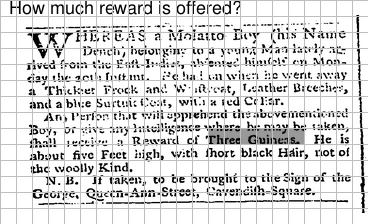

In [13]:
im = Image.open("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/pixel_runaways_overlay.png")
im = im.convert("RGB")
im = np.asarray(im)
im = draw_grid(im)
vis = Image.fromarray(im)
vis = vis.crop((0, 0, 368, 224))
vis